<h1>IMAGE PYRAMID TUTORIAL</h1> 
A brief introduction to multi-scale pyramid decompositions for image 
processing.  You should go through this, reading the comments, and
executing the corresponding Python instructions.  This file assumes 
a basic familiarity with matrix algebra, with linear systems and Fourier
theory, and with Python.  If you don't understand a particular
function call, execute "help(functionName)" to see documentation.
<p>
EPS, 6/96. Ported to iPython by Rob Young, 4/14<br>  
Based on the original OBVIUS tutorial.<br>

"Range: [1.0, 255.0]Dims: [256, 256]*1.00"

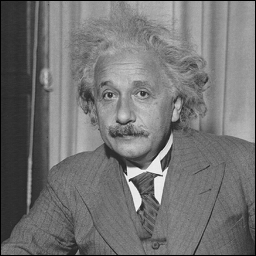

In [44]:
%matplotlib inline
# import image to a numpy array and display
import Image
import numpy as np
import pyPyrUtils as ppu
import matplotlib.pyplot as plt
import JBhelpers as jbh

im = np.array(Image.open('einsteinCorrect.pgm')).astype(float)
jbh.showIm(im)

<h2>Laplacian Pyramids:</h2>
Images may be decomposed into information at different scales.

"Range: [19.2, 234.1]Dims: [256, 256]*1.00"

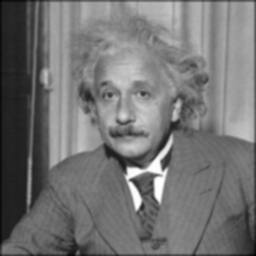

[[ 0.0625]
 [ 0.25  ]
 [ 0.375 ]
 [ 0.25  ]
 [ 0.0625]]
[[ 0.00390625  0.015625    0.0234375   0.015625    0.00390625]
 [ 0.015625    0.0625      0.09375     0.0625      0.015625  ]
 [ 0.0234375   0.09375     0.140625    0.09375     0.0234375 ]
 [ 0.015625    0.0625      0.09375     0.0625      0.015625  ]
 [ 0.00390625  0.015625    0.0234375   0.015625    0.00390625]]
[[ 20.375       24.2421875   30.          31.796875    31.625       31.5390625
   31.6640625   32.078125    32.5234375   32.609375  ]
 [ 24.4296875   29.09375     36.0078125   38.078125    37.71484375
   37.41015625  37.3671875   37.796875    38.421875    38.66796875]
 [ 30.3359375   36.19140625  44.8671875   47.4140625   46.82421875
   46.234375    45.91796875  46.2734375   47.109375    47.6484375 ]
 [ 31.8515625   38.09375     47.390625    50.203125    49.69140625
   49.2109375   48.90234375  49.1015625   49.84375     50.48046875]
 [ 31.2734375   37.42578125  46.58203125  49.42578125  49.22265625
   49.2265625   49.261

In [47]:
# Blurring eliminates the fine scales (detail):
binom5 = ppu.binomialFilter(5)
lo_filt = binom5*binom5.T
blurred = ppu.rconv2(im.copy(), lo_filt.copy())
jbh.showIm(blurred)
print binom5
print lo_filt
print blurred[:10,:10]

"Range: [-103.8, 86.3]Dims: [256, 256]*1.00"

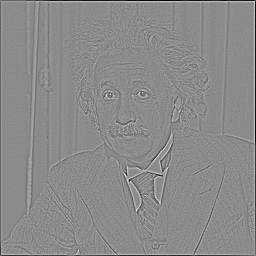

In [3]:
# subtracting the blurred image from the original leaves ONLY the fine scale detail:
fine0 = im - blurred
jbh.showIm(fine0)

The blurred and fine images contain all the information found in
the original image.  Trivially, adding the blurred image to the
fine scale detail will reconstruct the original.  We can compare
the original image to the sum of blurred and fine using the
"imStats" function, which reports on the statistics of the
difference between it's arguments:

In [4]:
ppu.imStats(im, blurred+fine0)

Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): inf


Since the filter is a lowpass filter, we might want to subsample
the blurred image.  This may cause some aliasing (depends on the
filter), but the decomposition structure given above will still be
possible.  The corrDn function correlates (same as convolution, but
flipped filter) and downsamples in a single operation (for
efficiency).  The string 'reflect1' tells the function to handle
boundaries by reflecting the image about the edge pixels.  Notice
that the blurred1 image is half the size (in each dimension) of the
original image.

pyPyrUtils.py:2548: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if image == None or filt == None:


"Range: [36.4, 432.1]Dims: [128, 128]*2.00"

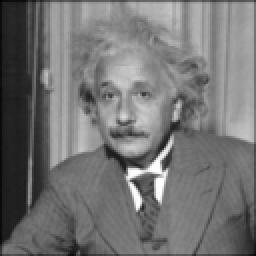

In [5]:
lo_filt = 2*binom5*binom5.T
blurred1 = ppu.corrDn(image = im.copy(), filt = lo_filt.copy(), step = (2,2))
jbh.showIm(blurred1, 'auto', 2)

pyPyrUtils.py:2588: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if image == None or filt == None:


"Range: [-116.8, 96.9]Dims: [256, 256]*1.00"

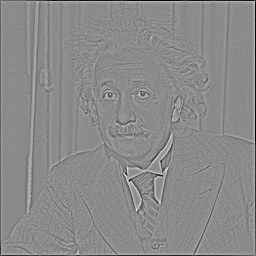

In [6]:
fine1 = im - ppu.upConv(image = blurred1.copy(), filt = lo_filt.copy(), step = (2, 2))
jbh.showIm(fine1)

We now have a technique that takes an image, computes two new
images (blurred1 and fine1) containing the coarse scale information
and the fine scale information.  We can also (trivially)
reconstruct the original from these two (even if the subsampling of
the blurred1 image caused aliasing):

In [7]:
recon = fine1 + ppu.upConv(image = blurred1.copy(), filt = lo_filt.copy(), step = (2, 2), start = (1, 1))
ppu.imStats(im, recon)

Difference statistics:
  Range: [-58, 59]
  Mean: 0.214451,  Stdev (rmse): 6.439134,  SNR (dB): 15.213439


Thus, we have described an INVERTIBLE linear transform that maps an
input image to the two images blurred1 and fine1.  The inverse
transformation maps blurred1 and fine1 to the result.  This is
depicted graphically with a system diagram:
<pre>
 IM --> blur/down2 ---------> BLURRED1 --> up2/blur --> add --> RECON
  |                   |                                  ^
  |                   |                                  |
  |                   V                                  |
  |                up2/blur                              |
  |                   |                                  |
  |                   |                                  |
  |                   V                                  |
   --------------> subtract --> FINE1 -------------------
</pre>
Note that the number of samples in the representation (i.e., total
samples in BLURRED1 and FINE1) is 1.5 times the number of samples
in the original IM.  Thus, this representation is OVERCOMPLETE.

"Range: [127.6, 848.0]Dims: [64, 64]*4.00"

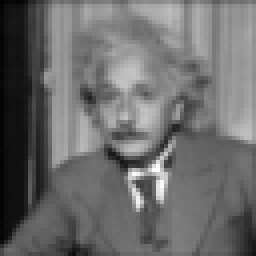

In [8]:
blurred2 = ppu.corrDn(image = blurred1.copy(), filt = lo_filt.copy(), step = (2, 2))
jbh.showIm(blurred2, 'auto', 4)

"Range: [-183.6, 195.8]Dims: [128, 128]*2.00"

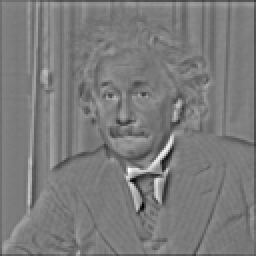

In [9]:
fine2 = blurred1 - ppu.upConv(image = blurred2.copy(), filt = lo_filt.copy(), step = (2, 2), start = (1, 1))
jbh.showIm(fine2, 'auto', 2)

Since blurred2 and fine2 can be used to reconstruct blurred1, and
blurred1 and fine1 can be used to reconstruct the original image,
the set of THREE images (also known as "subbands") {blurred2,
fine2, fine1} constitute a complete representation of the original
image.  Note that the three subbands are displayed at the same size,
but they are actually three different sizes.

"Range: [-116.8, 96.9]Dims: [256, 256]*1.00","Range: [-183.6, 195.8]Dims: [128, 128]*2.00","Range: [127.6, 848.0]Dims: [64, 64]*4.00"

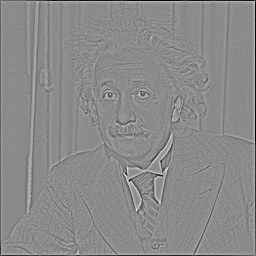
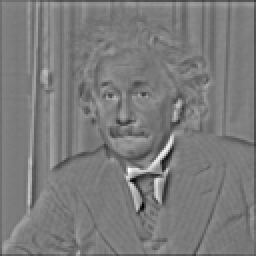
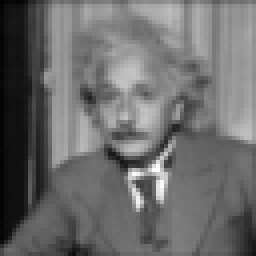

In [10]:
jbh.showIm([fine1, fine2, blurred2], 'auto', [1,2,4], "", 256, 3)

It is useful to consider exactly what information is stored in each
of the pyramid subbands.  The reconstruction process involves
recursively interpolating these images and then adding them to the
image at the next finer scale.  To see the contribution of ONE of
the representation images (say blurred2) to the reconstruction, we
imagine filling all the other subbands with zeros and then
following our reconstruction procedure.  For the blurred2 subband,
this is equivalent to simply calling upConv twice:

"Range: [31.9, 202.9]Dims: [256, 256]*1.00"

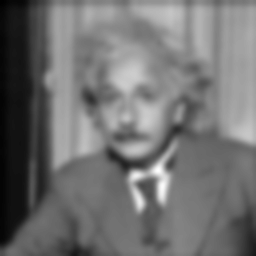

In [11]:
blurred2_tmp = ppu.upConv(image = blurred2.copy(), filt = lo_filt.copy(), step = (2, 2), start = (1, 1))
blurred2_full = ppu.upConv(image = blurred2_tmp.copy(), filt = lo_filt.copy(), step = (2, 2), start = (1, 1))
jbh.showIm(blurred2_full)

"Range: [-79.3, 88.5]Dims: [256, 256]*1.00"

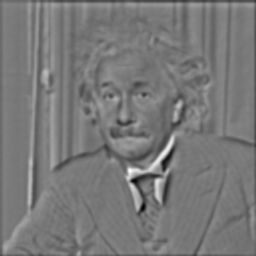

In [12]:
# For the fine2 subband, this is equivalent to calling upConv once:
fine2_full = ppu.upConv(image = fine2.copy(), filt = lo_filt.copy(), step = (2, 2), start = (1, 1))
jbh.showIm(fine2_full)

In [13]:
# If we did everything correctly, we should be able to add together
# these three full-size images to reconstruct the original image:
recon = blurred2_full + fine2_full + fine1
ppu.imStats(im, recon)

Difference statistics:
  Range: [-58, 59]
  Mean: 0.214451,  Stdev (rmse): 6.439134,  SNR (dB): 15.213439


<h2>FUNCTIONS for CONSTRUCTING/MANIPULATING LAPLACIAN PYRAMIDS</h2>
We can continue this process, recursively splitting off finer and
finer details from the blurred image (like peeling off the outer
layers of an onion).  The resulting data structure is known as a
"Laplacian Pyramid".  To make things easier, we have written a
MatLab function called buildLpyr to construct this object.  The
function returns two items: a long vector containing the subbands
of the pyramid, and an index matrix that is used to access these
subbands.  The display routine showLpyr shows all the subbands of the
pyramid, at the their correct relative sizes.  It should now be
clearer why these data structures are called "pyramids".

"Range: [-268.0, 458.5]Dims: [256, 385]*1.00"

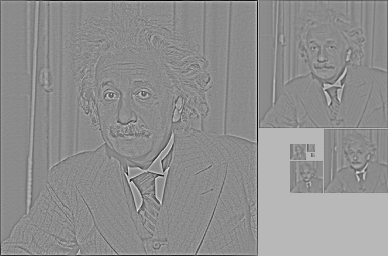

In [14]:
import pyPyrTools as ppt
pyr = ppt.Lpyr(im) 
pyr.showPyr(disp='nb')

"Range: [-116.8, 96.9]Dims: [256, 256]*1.00"

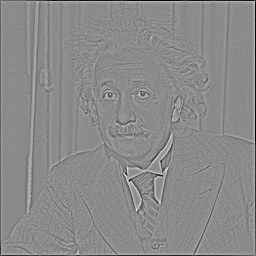

In [15]:
# There are also "accessor" functions for pulling out a single subband:
jbh.showIm(pyr.band(0))

pyPyrTools.py:1217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if levs == 'all':


"Range: [-125.4, 103.0]Dims: [256, 256]*1.00"

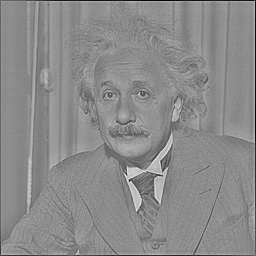

In [16]:
# The reconLpyr function allows you to reconstruct from a laplacian pyramid.
# The third (optional) arg allows you to select any subset of pyramid bands
# (default is to use ALL of them).
jbh.showIm(pyr.reconPyr([0,2]))  # reconstruct with just the first and third band

"Range: [0.0, 237.0]Dims: [256, 256]*1.00"

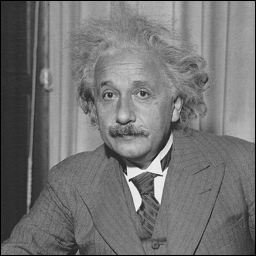

Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): inf


In [17]:
fullres = pyr.reconPyr()
jbh.showIm(fullres)
ppu.imStats(im,fullres)

[[ 0.35355339]
 [ 0.70710678]
 [ 0.35355339]]


"Range: [-316.5, 450.8]Dims: [256, 385]*1.00"

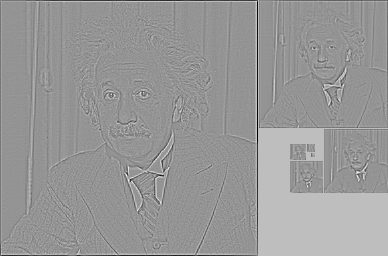

Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): inf


In [18]:
# buildLpyr uses 5-tap filters by default for building Laplacian
# pyramids.  You can specify other filters:
print ppu.namedFilter('binom3')
pyr3 = ppt.Lpyr(im, 7, 'binom3')
pyr3.showPyr(disp='nb')
fullres3 = pyr3.reconPyr('all','binom3')
ppu.imStats(im,fullres3)

Here we build a "Laplacian" pyramid using random filters.  filt1 is
used with the downsampling operations and filt2 is used with the
upsampling operations.  We normalize the filters for display
purposes.  Of course, these filters are (almost certainly) not very
"Gaussian", and the subbands of such a pyramid will be garbage!
Nevertheless, it is a simple property of the Laplacian pyramid that
we can use ANY filters and we will still be able to reconstruct
perfectly.

"Range: [-162.0, 338.6]Dims: [256, 385]*1.00"

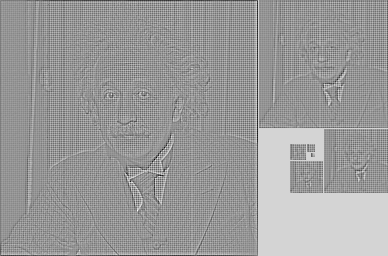

Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): 342.089510


In [19]:
filt1 = np.random.rand(5,1)
filt1 = np.sqrt(2)*filt1/sum(filt1)
filt2 = np.random.rand(3,1)
filt2 = np.sqrt(2)*filt2/sum(filt2)
pyrr = ppt.Lpyr(im, 7, filt1, filt2)
pyrr.showPyr(disp='nb')
fullresr = pyrr.reconPyr('all',filt2)
ppu.imStats(im,fullresr)

<h2>ALIASING in the Gaussian and Laplacian pyramids:</h2>
Unless one is careful, the subsampling operations will introduce aliasing
artifacts in these pyramid transforms.  This is true even though the
Laplacian pyramid can be used to reconstruct the original image perfectly.
When reconstructing, the pyramid is designed in such a way that these
aliasing artifacts cancel out.  So it's not a problem if the only thing we
want to do is reconstruct.  However, it can be a serious problem if we
intend to process each of the subbands independently.
<p>
One way to see the consequences of the aliasing artifacts is by
examining variations that occur when the input is shifted.  We
choose an image and shift it by some number of pixels.  Then blur
(filter-downsample-upsample-filter) the original image and blur the
shifted image.  If there's no aliasing, then the blur and shift
operations should commute (i.e.,
shift-filter-downsample-upsample-filter is the same as
filter-downsample-upsample-filter-shift).  Try this for 2 different
filters (by replacing 'binom3' with 'binom5' or 'binom7' below),
and you'll see that the aliasing is much worse for the 3 tap
filter.

Difference statistics:
  Range: [-63, 58]
  Mean: 0.000000,  Stdev (rmse): 41.732490,  SNR (dB): 4.038652


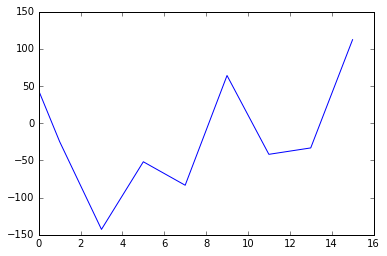

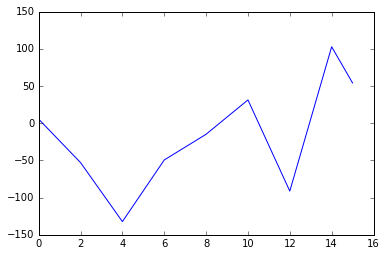

In [20]:
sig = 100*np.random.randn(1, 16)
sh = (0,7)   #shift amount
lev = 2   # level of pyramid to look at
flt = ppu.namedFilter('binom3') #filter to use: 

shiftIm = ppu.shift(sig,sh)
pyr = ppt.Lpyr(shiftIm, lev, flt, flt, 'circular')
shiftBlur = pyr.reconPyr(lev-1, flt, 'circular')

pyr2 = ppt.Lpyr(sig, lev, flt, flt, 'circular')
res = pyr2.reconPyr(lev-1, flt, 'circular')
blurShift = ppu.shift(res,sh)

plt.plot(blurShift.T)
plt.figure()
plt.plot(shiftBlur.T)

ppu.imStats(blurShift,shiftBlur)

<h2>PROJECTION and BASIS functions:</h2>

An invertible, linear transform can be characterized in terms
of a set of PROJECTION and BASIS functions.  In python matrix
notation:<br>
    c = np.dot(P', x)<br>
    x = np.dot(B, c)<br>
where x is an input, c are the transform coefficients, P and B
are matrices.  The columns of P are the projection functions (the
input is projected onto the the columns of P to get each successive
transform coefficient).  The columns of B are the basis
functions (x is a linear combination of the columns of B).
<p>
Since the Laplacian pyramid is a linear transform, we can ask: what
are its BASIS functions?  We consider these in one dimension for
simplicity.  The BASIS function corresponding to a given
coefficient tells us how much that coefficient contributes to each
pixel in the reconstructed image.  We can construct a single basis
function by setting one sample of one subband equal to 1.0 (and all
others to zero) and reconstructing. To build the entire matrix, we
have to do this for every sample of every subband:

"Range: [0.0, 1.0]Dims: [36, 68]*4.00"

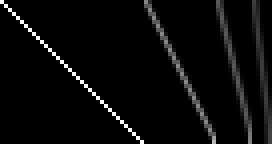

In [21]:
from operator import mul
sz = 36
sig = np.zeros((1,sz));
pyr = ppt.Lpyr(sig)

# find size of basis
Nelements = 0
for n in range(pyr.height):
    Nelements += reduce(mul, pyr.pyrSize[n])

basis = np.zeros((sz, Nelements))
ctr = 0
for n in range(pyr.height):
    for i in range(pyr.pyrSize[n][1]):
        pyr.set(n,(0,i),1)
        basis[:,ctr] = pyr.reconPyr()
        ctr += 1
        pyr.set(n,(0,i),0)
jbh.showIm(basis, 'auto', 4)

The columns of the basis matrix are the basis functions.  The
matrix is short and fat, corresponding to the fact that the
representation is OVERCOMPLETE.  Below, we plot the middle one from
each subband, starting with the finest scale.  Note that all of
these basis functions are lowpass (Gaussian-like) functions.

0.0
18.0
0.0
45.0
0.5
58.0
0.25
65.0


/users-local/ryoung/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


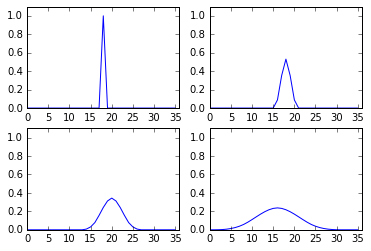

In [22]:
locations = ppu.round(sz * (2 - 3./2.**np.array(range(1,len(pyr.pyrSize)+1))))
for lev in range(len(locations)):
    plt.subplot(2,2,lev+1)
    plt.plot(basis[:,locations[lev]])
    plt.axis([0, sz, 0, 1.1])

Now, we'd also like see the inverse (we'll them PROJECTION)
functions. We need to ask how much of each sample of the input
image contributes to a given pyramid coefficient.  Thus, the matrix
is constructed by building pyramids on the set of images with
impulses at each possible location.  The rows of this matrix are
the projection functions.

"Range: [-0.4, 0.8]Dims: [68, 36]*4.00"

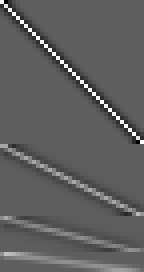

In [23]:
projection = np.zeros((Nelements,sz))
for pos in range(sz):
    pyr = ppt.Lpyr(ppu.mkImpulse((1, sz), (0, pos)).T)
    projection[:,pos] = pyr.catBands()
jbh.showIm(projection, 'auto', 4)

Building a pyramid corresponds to multiplication by the projection
matrix.  Reconstructing from this pyramid corresponds to
multiplication by the basis matrix.  Thus, the product of the two
matrices (in this order) should be the identity matrix:

"Range: [-0.0, 1.0]Dims: [36, 36]*4.00"

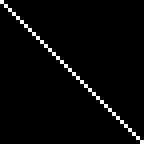

In [24]:
jbh.showIm(np.dot(basis, projection), 'auto', 4)

We can plot a few example projection functions at different scales.
Note that all of the projection functions are bandpass functions,
except for the coarsest subband which is lowpass.

/users-local/ryoung/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


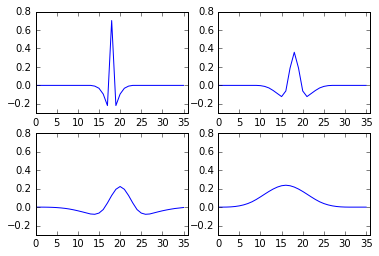

In [25]:
for lev in range(locations.shape[0]):
    plt.subplot(2,2,lev+1)
    plt.plot(projection[locations[lev]])
    plt.axis([0, sz, -0.3, 0.8])

Now consider the frequency response of these functions, plotted over the
range [-pi,pi]:

/users-local/ryoung/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


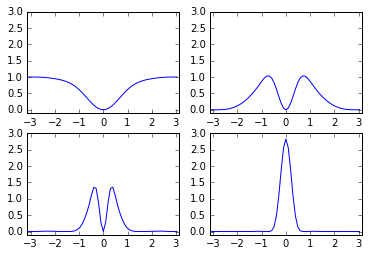

In [26]:
for lev in range(len(locations)):
    plt.subplot(2,2,lev+1)
    proj = projection[locations[lev]]
    plt.plot(np.pi*np.array(range(-32,32))/32, np.fft.fftshift(np.abs(np.fft.fft(proj.T,64))))
    plt.axis([-np.pi, np.pi, -0.1, 3])

The first projection function is highpass, and the second is bandpass.  Both
of these look something like the Laplacian (2nd derivative) of a Gaussian.
The last is lowpass, as are the basis functions.  Thus, the basic operation
used to create each level of the pyramid involves a simple highpass/lowpass
split.

<h2>QMF/WAVELET PYRAMIDS.</h2>

Two things about Laplacian pyramids are a bit unsatisfactory.
First, there are more pixels (coefficients) in the representation
than in the original image. Specifically, the 1-dimensional
transform is overcomplete by a factor of 4/3, and the 2-dimensional
transform is overcomplete by a factor of 2.  Secondly, the
"bandpass" images (fineN) do not segregate information according to
orientation.
<p>
There are other varieties of pyramid.  One type that arose in the
speech coding community is based on a particular pairs of filters
known as a "Quadrature Mirror Filters" or QMFs.  These are closely
related to Wavelets (essentially, they are approximate wavelet
filters).
<p>
Recall that the Laplacian pyramid is formed by simple hi/low
splitting at each level.  The lowpass band is subsampled by a
factor of 2, but the highpass band is NOT subsampled.  In the QMF
pyramid, we apply two filters (hi- and lo- pass) and subsample BOTH
by a factor of 2, thus eliminating the excess coefficients of the
Laplacian pyramid.
<p>
The two filters must have a specific relationship to each
other. In particular, let n be an index for the filter samples.
The highpass filter may be constructed from the lowpass filter by
(1) modulating (multiplying) by (-1)^n (equivalent to shifting by
pi in the Fourier domain), (2) flipping (i.e., reversing the order
of the taps), (3) spatially shifting by one sample.  Try to
convince yourself that the resulting filters will always be
orthogonal to each other (i.e., their inner products will be zero)
when shifted by any multiple of two.

The function modulateFlip performs the first two of these operations.  The
third (spatial shifting) step is built into the convolution code.

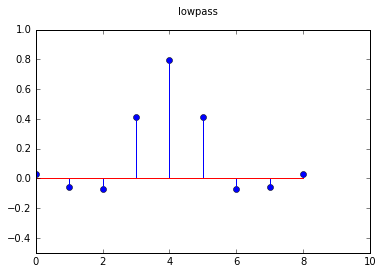

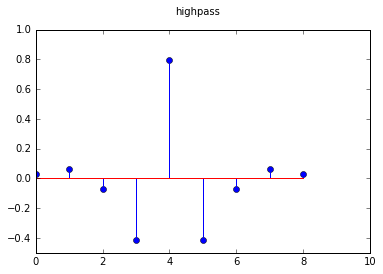

In [27]:
#flo = ppu.namedFilter('qmf9').reshape(9)
#fhi = ppu.modulateFlip(flo).reshape(9)
flo = ppu.namedFilter('qmf9').copy()
fhi = ppu.modulateFlip(flo).T.copy()
x = np.array(range(9))
plt.stem(x, flo)
plt.axis([0, 10, -0.5, 1.0])
plt.suptitle('lowpass')
plt.figure()
plt.stem(x, fhi)
plt.axis([0, 10, -0.5, 1.0])
plt.suptitle('highpass')

In the Fourier domain, these filters are (approximately)
"power-complementary": the sum of their squared power spectra is
(approximately) a constant.  But note that neither is a perfect
bandlimiter (i.e., a sinc function), and thus subsampling by a
factor of 2 will cause aliasing in each of the subbands.  See below
for a discussion of the effect of this aliasing.

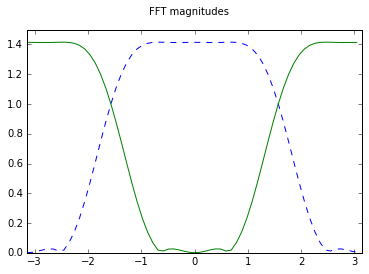

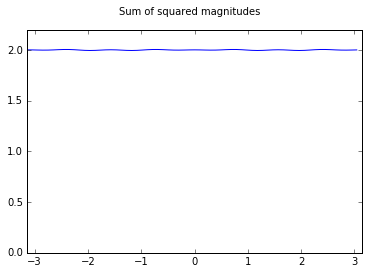

In [28]:
# Plot the two frequency responses:
freq = np.pi*np.array(range(-32,32))/32
plt.plot(freq, np.fft.fftshift(np.abs(np.fft.fft(flo.T,64))).T, '--', freq, np.fft.fftshift(np.abs(np.fft.fft(fhi.T,64))).T,'-')
plt.axis([-np.pi, np.pi, 0, 1.5])
plt.suptitle('FFT magnitudes')
plt.figure()
plt.plot(freq, np.fft.fftshift(np.abs(np.fft.fft(flo.T,64))**2).T + np.fft.fftshift(np.abs(np.fft.fft(fhi.T,64))**2).T)
plt.axis([-np.pi, np.pi, 0, 2.2])
plt.suptitle('Sum of squared magnitudes')

pyPyrUtils.py:2131: RuntimeWarning: divide by zero encountered in power
  res = (xramp2**2 + yramp2**2)**(expt/2.0)


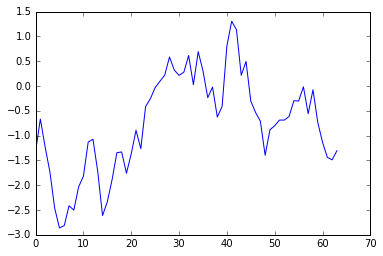

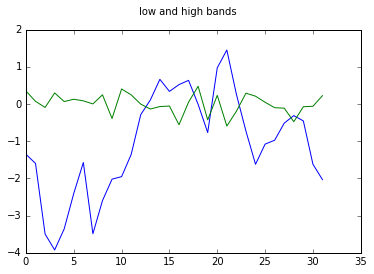

In [29]:
# We can split an input signal into two bands as follows:
sig = ppu.mkFract((1,64), 1.6)
plt.plot(sig.T)
lo1 = ppu.corrDn(image = sig.copy(), filt = flo.T.copy(), step = (1, 2))
plt.figure()
plt.plot(lo1.T)
hi1 = ppu.corrDn(image = sig.copy(), filt = fhi.T.copy(), step = (1, 2), start = (0, 1))
plt.plot(hi1.T)
plt.suptitle('low and high bands')

Notice that the two subbands are half the size of the original
image, due to the subsampling by a factor of 2.  One subtle point:
the highpass and lowpass bands are subsampled on different
lattices: the lowpass band retains the odd-numbered samples and the
highpass band retains the even-numbered samples.  This was the
1-sample shift relating the high and lowpass kernels (mentioned
above).  We've used the 'reflect1' to handle boundaries, which
works properly for symmetric odd-length QMFs.

Difference statistics:
  Range: [-1, 7]
  Mean: 2.728261,  Stdev (rmse): 1.403236,  SNR (dB): -2.942617


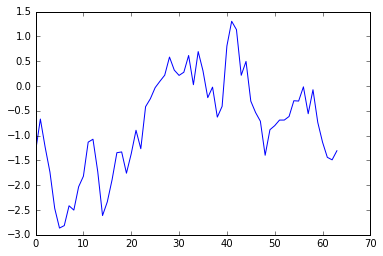

In [42]:
# We can reconstruct the original image by interpolating these two subbands
# USING THE SAME FILTERS:
reconlo = ppu.upConv(image = lo1.copy(), filt = flo.T.copy(), step = (1, 2))
reconhi = ppu.upConv(image = hi1.copy(), filt = fhi.T.copy(), step = (1, 2), start = (0, 1))
plt.plot((reconlo+reconhi).T)
ppu.imStats(sig, (reconlo+reconhi).T)

We have described an INVERTIBLE linear transform that maps an input
image to the two images lo1 and hi1.  The inverse transformation
maps these two images to the result.  This is depicted graphically
with a system diagram:
<pre>
IM ---> flo/down2 --> LO1 --> up2/flo --> add --> RECON
    |                                      ^
    |	                                  |
    |	                                  |
     -> fhi/down2 --> HI1 --> up2/fhi ----- 
</pre> 

Note that the number of samples in the representation (i.e., total
samples in LO1 and HI1) is equal to the number of samples in the
original IM.  Thus, this representation is exactly COMPLETE, or
"critically sampled".

So we've fixed one of the problems that we had with Laplacian
pyramid.  But the system diagram above places strong constraints on
the filters.  In particular, for these filters the reconstruction
is no longer perfect.  Turns out there are NO
perfect-reconstruction symmetric filters that are
power-complementary, except for the trivial case [1] and the
nearly-trivial case [1 1]/sqrt(2).

Let's consider the projection functions of this 2-band splitting
operation.  We can construct these by applying the transform to
impulse input signals, for all possible impulse locations.  The
rows of the following matrix are the projection functions for each
coefficient in the transform.

In [31]:
#M = np.concatenate((ppu.corrDn(image = np.identity(32).copy(), filt = flo.copy(), edges = 'circular', step = (2, 1)),
#                    ppu.corrDn(image = np.identity(32).copy(), filt = fhi.copy(), edges = 'circular', step = (2, 1), 
#                               start = (1, 0))))
#jbh.showIm(M, 'auto', 5, "M")

The transform matrix is composed of two sub-matrices.  The top half
contains the lowpass kernel, shifted by increments of 2 samples.
The bottom half contains the highpass.  Now we compute the inverse
of this matrix: 

In [32]:
#M_inv = np.linalg.inv(M)
#jbh.showIm(M_inv, 'auto', 5, "M_inv")

The inverse is (very close to) the transpose of the original
matrix!  In other words, the transform is orthonormal.

In [33]:
#ppu.imStats(M_inv.T,M)

This also points out a nice relationship between the corrDn and
upConv functions, and the matrix representation.  corrDn is
equivalent to multiplication by a matrix with copies of the filter
on the ROWS, translated in multiples of the downsampling factor.
upConv is equivalent to multiplication by a matrix with copies of
the filter on the COLUMNS, translated by the upsampling factor.

As in the Laplacian pyramid, we can recursively apply this QMF 
band-splitting operation to the lowpass band:

In [34]:
#print flo
#print fhi
#print lo1
#lo2 = ppu.corrDn(image = lo1.T.copy(), filt = flo.copy(), step = (1, 2)).T
#hi2 = ppu.corrDn(image = lo1.T.copy(), filt = fhi.copy(), step = (1, 2), start = (0, 1)).T
##lo2 = ppu.corrDn(image = lo1.copy(), filt = flo.copy(), step = (2, 1))
##hi2 = ppu.corrDn(image = lo1.copy(), filt = fhi.copy(), step = (2, 1), start = (1, 0))

The representation of the original signal is now comprised of the
three subbands {hi1, hi2, lo2} (we don't hold onto lo1, because it
can be reconstructed from lo2 and hi2).  Note that hi1 is at 1/2
resolution, and hi2 and lo2 are at 1/4 resolution: The total number
of samples in these three subbands is thus equal to the number of
samples in the original signal.

In [35]:
#plt.plot(hi1)
#plt.suptitle('hi1')
#plt.axis([1, len(hi1), 1.1*hi1.min(), 1.1*hi1.max()])
#plt.figure()
#plt.plot(hi2)
#plt.suptitle('hi2')
#plt.axis([1, hi2.shape[0], 1.1*hi2.min(), 1.1*hi2.max()])
#plt.figure()
#plt.plot(lo2)
#plt.suptitle('lo2')
#plt.axis([1, len(lo2), 1.1*lo2.min(), 1.1*lo2.max()])

Reconstruction proceeds as with the Laplacian pyramid: combine lo2 and hi2
to reconstruct lo1, which is then combined with hi1 to reconstruct the
original signal:

In [36]:
#recon_lo1 = ( ppu.upConv(image = hi2.T, filt = fhi, step = (1, 2), start = (0, 1)) +
#              ppu.upConv(image = lo2.T, filt = flo, step = (1, 2), start = (0, 0)) )
#reconstructed = ( ppu.upConv(image = hi1.T, filt = fhi, step = (1, 2), start = (0, 1)) +
#                  ppu.upConv(image = recon_lo1, filt = flo, step = (1, 2), start = (0, 0)) )
#ppu.imStats(sig,reconstructed)

<h2>FUNCTIONS for CONSTRUCTING/MANIPULATING QMF/Wavelet PYRAMIDS</h2>
To make things easier, we have bundled these qmf operations and
data structures into an object in Python.

In [37]:
sig = ppu.mkFract((1, 64), 1.5)
pyr = ppt.Wpyr(sig)
pyr.showPyr(disp='nb')
#for b in range(pyr.nbands()):
#    plt.figure()
#    x = np.array(range(pyr.band(b).shape[1]))
#    y = pyr.band(b).reshape(pyr.band(b).shape[1])
#    plt.stem(x, y)
#    plt.axis([-1, pyr.band(b).shape[1], 1.1*min(min(pyr.band(b))), 1.1*max(max(pyr.band(b)))])

#res = pyr.reconPyr()
#ppu.imStats(sig, res)

NameError: global name 'fig' is not defined

Now for 2D, we use separable filters.  There are 4 ways to apply the two 
filters to the input image (followed by the relavent subsampling operation):<ol>
  <li> lowpass in both x and y
  <li> lowpass in x and highpass in y 
  <li> lowpass in y and highpass in x
  <li> highpass in both x and y.</ol>  
The pyramid is built by recursively subdividing the first of these bands
into four new subbands.

In [ ]:
# First, we'll take a look at some of the basis functions.
sz = 40
zim = np.zeros((sz,sz))
flo = 'qmf9'
edges = 'reflect1'
pyr = ppt.Wpyr(zim)

In [ ]:
# Put an  impulse into the middle of each band:
for lev in range(len(pyr.pyrSize)):
    mid = (pyr.pyrSize[lev][0]/2, pyr.pyrSize[lev][1]/2)
    pyr.set(lev, mid, 1)

In [ ]:
# And take a look at the reconstruction of each band:
reconList = []
for lnum in range(int(pyr.wpyrHt())+1):
    for bnum in range(3):
        reconList.append(pyr.reconPyr(flo, edges, [lnum], [bnum]))
jbh.showIm(reconList, 'auto', 4, "", 256, 3)

Note that the first column contains horizontally oriented basis functions at
different scales.  The second contains vertically oriented basis functions.
The third contains both diagonals (a checkerboard pattern).  The bottom row
shows (3 identical images of) a lowpass basis function.

Now look at the corresponding Fourier transform magnitudes (these
are plotted over the frequency range [-pi, pi] ):

In [ ]:
freq = 2 * np.pi * np.array(range(-sz/2,(sz/2)))/sz
imgList = []
for lnum in range(int(pyr.wpyrHt())+1):
    for bnum in range(3):
        basisFn = pyr.reconPyr(flo, edges, [lnum], [bnum])
        basisFmag = np.fft.fftshift(np.abs(np.fft.fft2(basisFn,(sz,sz))))
        imgList.append(basisFmag)
jbh.showIm(imgList, 'auto', 4, '', 256, 3)

In [ ]:
# The filters at a given scale sum to a squarish annular region:
sumSpectra = np.zeros((sz,sz))
lnum = 2;
for bnum in range(3):
    basisFn = pyr.reconPyr(flo, edges, [lnum], [bnum])
    basisFmag = np.fft.fftshift(np.abs(np.fft.fft2(basisFn,(sz,sz))))
    sumSpectra = basisFmag**2 + sumSpectra;
jbh.showIm(sumSpectra, 'auto', 4, 'one scale')

In [ ]:
# Now decompose an image:
pyr = ppt.Wpyr(im)

In [ ]:
# View all of the subbands (except lowpass), scaled to be the same size
# (requires a big figure window):
nlevs = int(pyr.wpyrHt())
imgList = []
for lnum in range(nlevs):
    for bnum in range(3):
        imgList.append(pyr.band((3*lnum)+bnum))
jbh.showIm(imgList, 'auto', [1,1,1,2,2,2,4,4,4,8,8,8,16,16,16], "", 256, 3)

In [ ]:
#In addition to the bands shown above, there's a lowpass residual:
jbh.showIm(pyr.pyrLow(), 'auto', 8)

In [ ]:
# Alternatively, display the pyramid with the subbands shown at their
# correct relative sizes:
pyr.showPyr(disp='nb')

In [ ]:
# The reconWpyr function can be used to reconstruct the entire pyramid:
reconstructed = pyr.reconPyr()
ppu.imStats(im,reconstructed)

In [ ]:
# As with Laplacian pyramids, you can specify sub-levels and subbands
# to be included in the reconstruction.  For example:
jbh.showIm(pyr.reconPyr('qmf9', 'reflect1', np.array(range(int(pyr.wpyrHt())-1)), [0]))  # Horizontal only
jbh.showIm(pyr.reconPyr('qmf9', 'reflect1', [1,2]))  # two middle scales

<h2>PERFECT RECONSTRUCTION: HAAR AND DEBAUCHIES WAVELETS</h2>

The symmetric QMF filters used above are not perfectly orthogonal.
In fact, it's impossible to construct a symmetric filter of size
greater than 2 that is perfectly orthogonal to shifted copies
(shifted by multiples of 2) of itself.  For example, consider a
symmetric kernel of length 3.  Shift by two and the right end of
the original kernel is aligned with the left end of the shifted
one.  Thus, the inner product of these two will be the square of
the end tap, which will be non-zero.

However, one can easily create wavelet filters of length 2 that
will do the job.  This is the oldest known wavelet, known as the
"Haar".  The two kernels are [1,1]/sqrt(2) and [1,-1]/sqrt(2).
These are trivially seen to be orthogonal to each other, and shifts
by multiples of two are also trivially orthogonal.  The projection
functions of the Haar transform are in the rows of the following
matrix, constructed by applying the transform to impulse input
signals, for all possible impulse locations:

In [ ]:
haarLo = ppu.namedFilter('haar')
haarHi = ppu.modulateFlip(haarLo).T
x = np.array(range(len(haarLo)))
plt.stem(x,haarLo)
plt.axis([-0.2, 1.2, -1, 1])
plt.suptitle('lowpass')
plt.figure()
plt.stem(x, haarHi)
plt.axis([-0.2, 1.2, -1, 1])
plt.suptitle('highpass')

In [ ]:
#M = np.concatenate( (ppu.corrDn(image = np.identity(32), filt = haarLo.T, step = (2, 1)),
#                     ppu.corrDn(image = np.identity(32), filt = haarHi, step = (2, 1), start = (1, 0))), axis=1).T
M = np.concatenate( (ppu.corrDn(image = np.identity(32), filt = haarLo, step = (1, 2)),
                     ppu.corrDn(image = np.identity(32), filt = haarHi.T, step = (1, 2), start = (0, 1))),
                     axis=1).T
jbh.showIm(M, 'auto', 5)
jbh.showIm(np.dot(M, M.T), 'auto', 5)   # identity

In [ ]:
# As before, the filters are power-complementary (although the
# frequency isolation is rather poor, and thus the subbands will be
# heavily aliased):
a = (np.pi*np.array(range(-32,32))/32).reshape((64,1))
fhaarLo = (np.abs(np.fft.fft(haarLo.T, 64))**2).reshape((64,1))
plt.plot(a,fhaarLo,'--')
fhaarHi = (np.abs(np.fft.fft(haarHi.T, 64))**2).reshape((64,1))
plt.plot(a,fhaarHi,'-')
sig = ppu.mkFract((1,64),0.5)
pyr = ppt.Wpyr(sig,3,'haar','reflect1')
pyr.showPyr()

In [ ]:
# check perfect reconstruction:
res = pyr.reconPyr('haar', 'reflect1')
ppu.imStats(sig,res)

If you want perfect reconstruction, but don't like the Haar
transform, there's another option: drop the symmetry requirement.
Ingrid Daubechies developed one of the earliest sets of such
perfect-reconstruction wavelets.  The simplest of these is of
length 4:

In [ ]:
daub_lo = ppu.namedFilter('daub2')
daub_hi = ppu.modulateFlip(daub_lo)
# The daub_lo filter is constructed to be orthogonal to 2shifted
# copy of itself.  For example:
np.dot(np.concatenate((daub_lo,[[0],[0]])).T, np.concatenate(([[0],[0]],daub_lo)))

#M = np.concatenate((ppu.corrDn(image = np.identity(32), filt = daub_lo, edges = 'circular', step = (2, 1), start = (1, 0)).T,
#                    ppu.corrDn(image = np.identity(32), filt = daub_hi.T, edges = 'circular', step = (2, 1), start = (1, 0)).T), 
#    axis=0)
M = np.concatenate((ppu.corrDn(image = np.identity(32), filt = daub_lo, edges = 'circular', step = (1, 2), start = (0, 1)),
                    ppu.corrDn(image = np.identity(32), filt = daub_hi.T, edges = 'circular', step = (1, 2), start = (0, 1))), 
    axis=1).T
jbh.showIm(M, 'auto', 5)
jbh.showIm(np.dot(M, M.T), 'auto', 5)

In [ ]:
# Again, they're power complementary:
x = (np.pi*np.array(range(-32,32))/32).reshape((64,1))
fdlo = (np.abs(np.fft.fft(daub_lo.T,64))**2).reshape((64,1))
fdhi = (np.abs(np.fft.fft(daub_hi,64))**2).reshape((64,1))
plt.plot(x, fdlo, '--')
plt.plot(x, fdhi, '-')

In [ ]:
# The sum of the power spectra is again flat
plt.plot(x, (np.fft.fftshift(np.abs(np.fft.fft(daub_lo.T,64))**2) + 
             np.fft.fftshift(np.abs(np.fft.fft(daub_hi,64))**2)).reshape(64,1))
plt.axis([-4, 4, 1.9, 2.1])

In [ ]:
# Make a pyramid using the same code as before (except that we can't
# use reflected boundaries with asymmetric filters):
pyr = ppt.Wpyr(sig, ppu.maxPyrHt(sig.shape[1],daub_lo.shape[0]), daub_lo, 'circular')
pyr.showPyr('indep1')

res = pyr.reconPyr(daub_lo,'circular')
ppu.imStats(sig,res)

<h2>ALIASING IN WAVELET TRANSFORMS</h2>
All of these orthonormal pyramid/wavelet transforms have a lot
of aliasing in the subbands.  You can see that in the frequency
response plots since the frequency response of each filter
covers well more than half the frequency domain.  The aliasing
can have serious consequences...

In [ ]:
# Get one of the basis functions of the 2D Daubechies wavelet transform:
pyr = ppt.Wpyr(np.zeros((1,64)),4,daub_lo,'circular')
lev = 2;
mid = int(np.ceil(pyr.pyrSize[lev][1]/2.0))
pyr.set(lev, mid, 1)
sig = pyr.reconPyr(daub_lo,'circular')
x = np.array(range(64)).reshape(64,1)
plt.stem(x,sig.T)
plt.axis([-2, 66, -0.65, 0.65])

In [ ]:
# Since the basis functions are orthonormal, building a pyramid using this
# input will yield a single non-zero coefficient.
pyr = ppt.Wpyr(sig, 4, daub_lo, 'circular')
nbands = len(pyr.pyrSize)
for b in range(nbands):
    plt.figure()
    plt.stem(range(pyr.band(b).shape[1]), pyr.band(b).T)
    plt.axis([-1, pyr.band(b).shape[1], -0.3, 1.3])

In [ ]:
# Now shift the input by one sample and re-build the pyramid.
shifted_sig = np.roll(sig,1)
spyr = ppt.Wpyr(shifted_sig, 4, daub_lo, 'circular')

# Plot each band of the unshifted and shifted decomposition
nbands = len(spyr.pyrSize)
for b in range(nbands):
    plt.figure()
    plt.stem(range(pyr.band(b).shape[1]), spyr.band(b).T)
    plt.axis([-1, pyr.band(b).shape[1], -0.3, 1.3])

In the third band, we expected the coefficients to move around
because the signal was shifted.  But notice that in the original
signal decomposition, the other bands were filled with zeros.
After the shift, they have significant content.  Although these
subbands are supposed to represent information at different scales,
their content also depends on the relative POSITION of the input
signal.

This problem is not unique to the Daubechies transform.  The same
is true for the QMF transform.  Try it...  In fact, the same kind
of problem occurs for almost any orthogonal pyramid transform (the
only exception is the limiting case in which the filter is a sinc
function).

Orthogonal pyramid transforms are not shift-invariant.  Although
orthogonality may be an important property for some applications
(e.g., data compression), orthogonal pyramid transforms are
generally not so good for image analysis.

The overcompleteness of the Laplacian pyramid turns out to be a
good thing in the end.  By using an overcomplete representation
(and by choosing the filters properly to avoid aliasing as much as
possible), you end up with a representation that is useful for
image analysis.

<h2>The "STEERABLE PYRAMID"</h2>

The steerable pyramid is a multi-scale representation that is
translation-invariant, but that also includes representation of
orientation.  Furthermore, the representation of orientation is
designed to be rotation-invariant. The basis/projection functions
are oriented (steerable) filters, localized in space and frequency.
It is overcomplete to avoid aliasing.  And it is "self-inverting"
(like the QMF/Wavelet transform): the projection functions and 
basis functions are identical.  The mathematical phrase for a 
transform obeying this property is "tight frame".

The system diagram for the steerable pyramid (described in the
reference given below) is as follows:<pre>
 IM ---> fhi0 -----------------> H0 ---------------- fhi0 ---> RESULT
     |                                                     |
     |                                                     |
     |-> flo0 ---> fl1/down2 --> L1 --> up2/fl1 ---> flo0 -|
               |                                 |
               |----> fb0 -----> B0 ----> fb0 ---|
               |                                 |
               |----> fb1 -----> B1 ----> fb1 ---|
               .                                 .
               .                                 .
               |----> fbK -----> BK ----> fbK ---|
</pre>
The filters {fhi0,flo0} are used to initially split the image into
a highpass residual band H0 and a lowpass subband.  This lowpass
band is then split into a low(er)pass band L1 and K+1 oriented
subbands {B0,B1,...,BK}.  The representatation is substantially
overcomplete.  The pyramid is built by recursively splitting the
lowpass band (L1) using the inner portion of the diagram (i.e.,
using the filters {fl1,fb0,fb1,...,fbK}).  The resulting transform is
overcomplete by a factor of 4k/3.

The scale tuning of the filters is constrained by the recursive
system diagram.  The orientation tuning is constrained by requiring
the property of steerability.  A set of filters form a steerable
basis if they 1) are rotated copies of each other, and 2) a copy of
the filter at any orientation may be computed as a linear
combination of the basis filters.  The simplest examples of
steerable filters is a set of N+1 Nth-order directional
derivatives.

In [ ]:
# Choose a filter set (options are 'sp0Filters', 'sp1Filters', 'sp3Filters', 'sp5Filters'):
filters = ppu.sp3Filters()
fsz = int(np.round(np.sqrt(filters['bfilts'].shape[0])))
fsz = np.array([fsz, fsz])
nfilts = filters['bfilts'].shape[1]
nrows = int(np.floor(np.sqrt(nfilts)))

import scipy.signal as sps
# Look at the oriented bandpass filters:
filtList = []
for f in range(nfilts):
    filtList.append(sps.convolve2d(filters['bfilts'][:,f].reshape(fsz), filters['lo0filt']))
jbh.showIm(filtList, 'auto', 4, '', 256, 4)

In [ ]:
# Try "steering" to a new orientation (new_ori in degrees):
new_ori = 360*np.random.rand(1)[0]
jbh.showIm(sps.convolve2d(ppu.steer(filters['bfilts'], new_ori*np.pi/180).reshape(fsz), filters['lo0filt']), 'auto', 4)

In [ ]:
# Look at Fourier transform magnitudes:
lo0filt = filters['lo0filt']
bfilts = filters['bfilts']
lo0 = np.fft.fftshift(np.abs(np.fft.fft2(filters['lo0filt'],(64,64))))
fsum = np.zeros(lo0.shape)
imgList = []
for f in range(bfilts.shape[1]):
    flt = bfilts[:,f].reshape(fsz)
    freq = lo0 * np.fft.fftshift(np.abs(np.fft.fft2(flt,(64,64))))
    fsum += freq**2
    imgList.append(freq)
jbh.showIm(imgList, 'auto', 3, '', 256, 4)

In [ ]:
# The filters sum to a smooth annular ring:
jbh.showIm(fsum, 'auto', 3)

In [ ]:
# build a Steerable pyramid:
pyr = ppt.Spyr(im, 4, 'sp3Filters')
# Look at first (vertical) bands, different scales:
imgList = []
for s in range(pyr.spyrHt()):
    band = pyr.spyrBand(s,0)
    imgList.append(band)
jbh.showIm(imgList, 'auto', [1, 2, 4, 8], '', 256, 4)

In [ ]:
# look at all orientation bands at one level (scale):
imgList = []
for b in range(pyr.numBands()):
    band = pyr.spyrBand(1,b)
    imgList.append(band)
jbh.showIm(imgList, 'auto', 2, '', 256, 4)

In [ ]:
# To access the high-pass and low-pass bands:
low = pyr.pyrLow()
jbh.showIm(low, 'auto', 16)
high = pyr.pyrHigh()
jbh.showIm(high)

In [ ]:
# Display the whole pyramid (except for the highpass residual band),
# with images shown at proper relative sizes:
pyr.showPyr(disp = 'nb')

In [ ]:
# Spin a level of the pyramid, interpolating (steering to)
# intermediate orienations:
lev = pyr.spyrLev(1)
n = lev[0].shape[0] * lev[0].shape[1]
lev2 = np.concatenate((lev[0].reshape((n,1)), lev[1].reshape((n,1)), lev[2].reshape((n,1)), lev[3].reshape((n,1))), axis=1)
jbh.showIm(pyr.spyrBand(2,1), 'auto', 4)
pySP3filt = ppu.sp3Filters()
M = np.empty((16, 128, 128))
for frame in range(16):
    steered_im = ppu.steer(lev2, 2*np.pi*frame/16, pySP3filt['harmonics'], pySP3filt['mtx']).reshape((128,128))
    M[frame,:,:] = steered_im
# need to load codecs
#jbh.nbvideo(M, fps = 10, loop = True, h264 = None, counter = "lr" )

In [ ]:
# Reconstruct.  Note that the filters are not perfect, although they are good
# enough for most applications.
res = pyr.reconPyr('sp1Filters')
jbh.showIm((im+1j*res).real)
ppu.imStats(im,res)

As with previous pyramids, you can select subsets of the levels
and orientation bands to be included in the reconstruction.  For example:

In [ ]:
# All levels (including highpass and lowpass residuals), one orientation:
jbh.showIm(pyr.reconPyr('sp3Filters','reflect1','all', [0]))

In [ ]:
# Without the highpass and lowpass:
jbh.showIm(pyr.reconPyr('sp3Filters','reflect1',range(1,pyr.spyrHt()+1), [0]))

We also provide an implementation of the Steerable pyramid in the
Frequency domain.  The advantages are perfect-reconstruction
(within floating-point error), and any number of orientation
bands.  The disadvantages are that it is typically slower, and the
boundary handling is always circular.

In [ ]:
pyr = ppt.SFpyr(im,4,4)    # 4 levels, 5 orientation bands
pyr.showPyr(disp = 'nb')
res = pyr.reconPyr()
ppu.imStats(im,res);  # nearly perfect

<h3>The steerable pyramid transform given above is described in:</h3>

E P Simoncelli and W T Freeman.<br>
The Steerable Pyramid: A Flexible Architecture for Multi-Scale 
Derivative Computation.<br>IEEE Second Int'l Conf on Image Processing.<br> 
Washington DC,  October 1995.

Online access:<br>
Abstract:  http://www.cis.upenn.edu/~eero/ABSTRACTS/simoncelli95b-abstract.html<br>
Full (PostScript):  ftp://ftp.cis.upenn.edu/pub/eero/simoncelli95b.ps.Z<br>